In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
train_dir = 'C:\\Users\\Jeffery Chan\\Desktop\\Group Project\\kaggle\\input\\intel-image-classification\\seg_train\\'
test_dir = 'C:\\Users\\Jeffery Chan\\Desktop\\Group Project\\kaggle\\input\\intel-image-classification\\seg_test\\'
pred_dir = 'C:\\Users\\Jeffery Chan\\Desktop\\Group Project\\kaggle\\input\\intel-image-classification\\seg_pred\\'

C:\Users\Jeffery Chan\Desktop\Group Project


In [ ]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 128

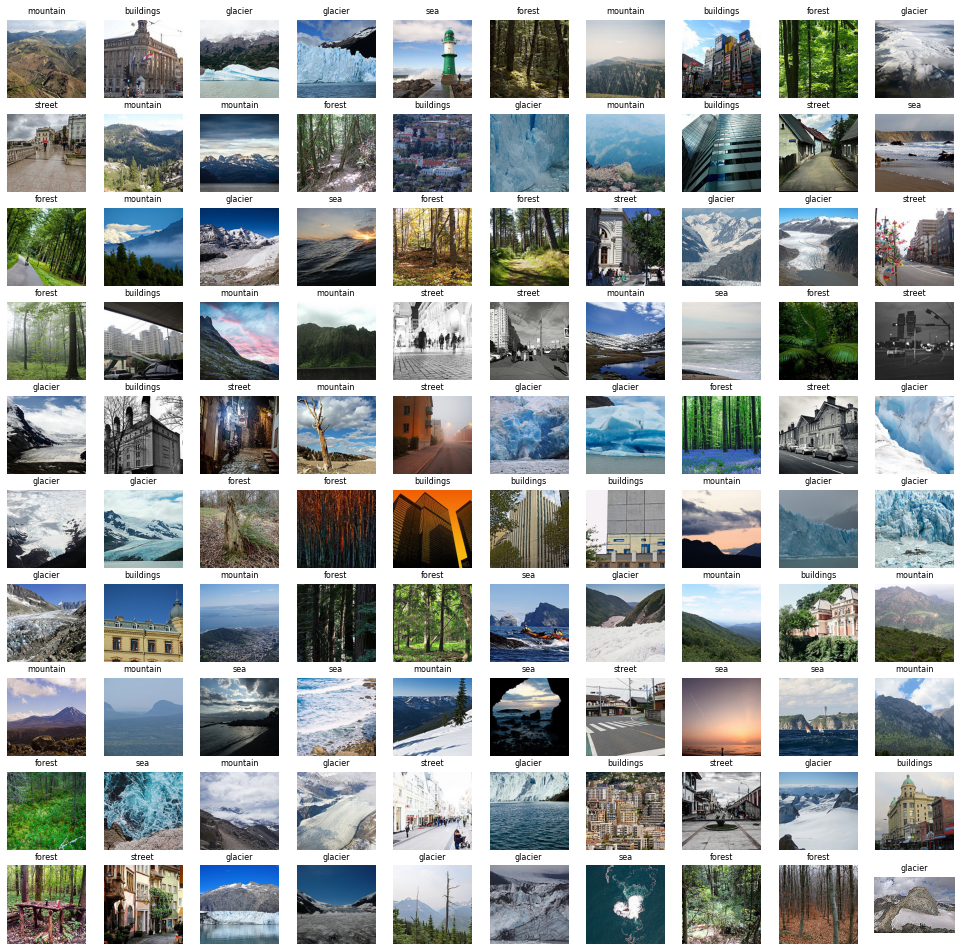

In [19]:
# visualize the training data
W = 10
H = 10
fig, axes = plt.subplots(W, H, figsize = (17,17))

axes = axes.ravel() # flaten the matrix into array
# Select a random number from 0 to n_training/ images will be selected randomly
for i in np.arange(0, W * H): 
    # Select a class randomly
    label = random.choice(os.listdir(train_dir))
    class_dir = os.path.join(train_dir,label)
    # Select a random image
    image = random.choice(os.listdir(class_dir))
    # read and display an image with the selected index    
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    #print(np.array(img).shape)
    axes[i].set_title(label, fontsize = 8) # the label
    axes[i].axis('off')

In [21]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                  rotation_range=20 ,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  brightness_range=[0.6,0.9],
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale = 1.0/255)

In [22]:
# --------------------
# Flow training images in batches of 128 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 128 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=128,
                                                         shuffle=False,
                                                         class_mode  = 'categorical',
                                                         target_size = (150, 150)) # it is very important to include shuffle=False otherwise confusion metrics will not correct

Found 14026 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [57]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


### Building Simple CNN Architecture

In [24]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 128 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(6, activation='softmax')])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_97 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_98 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_99 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 17, 17, 128)     

In [26]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [27]:
# fit the model
# early stopping: we can use EarlyStopping which is one of keras callbackes to stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor='loss', patience=5)
epoch = 20 # we can set it to a large value because there is early stopping

history = model.fit(train_generator, 
          epochs = epoch, 
          validation_data = validation_generator, 
          verbose = 1,
          steps_per_epoch = 110)
          callbacks = [earlystop]) # steps_per_epoch  = total number of samples // batch_size = 14034/128

Epoch 1/20
110/110 [==============================] - 477s 4s/step - loss: 1.1379 - accuracy: 0.5520 - val_loss: 0.8393 - val_accuracy: 0.6927
Epoch 2/20
110/110 [==============================] - 404s 4s/step - loss: 0.7949 - accuracy: 0.7061 - val_loss: 0.6930 - val_accuracy: 0.7483
Epoch 3/20
110/110 [==============================] - 711s 6s/step - loss: 0.6892 - accuracy: 0.7464 - val_loss: 0.7598 - val_accuracy: 0.7360
Epoch 4/20
110/110 [==============================] - 399s 4s/step - loss: 0.6019 - accuracy: 0.7811 - val_loss: 0.5977 - val_accuracy: 0.7923
Epoch 5/20
110/110 [==============================] - 401s 4s/step - loss: 0.5687 - accuracy: 0.7914 - val_loss: 0.5788 - val_accuracy: 0.8020
Epoch 6/20
110/110 [==============================] - 397s 4s/step - loss: 0.5177 - accuracy: 0.8102 - val_loss: 0.5667 - val_accuracy: 0.8023
Epoch 7/20
110/110 [==============================] - 400s 4s/step - loss: 0.4861 - accuracy: 0.8230 - val_loss: 0.5124 - val_accuracy: 0.8157

In [28]:
## Save the model
model.save('Basic_CNN.h5')
model = tf.keras.models.load_model('Basic_CNN.h5')

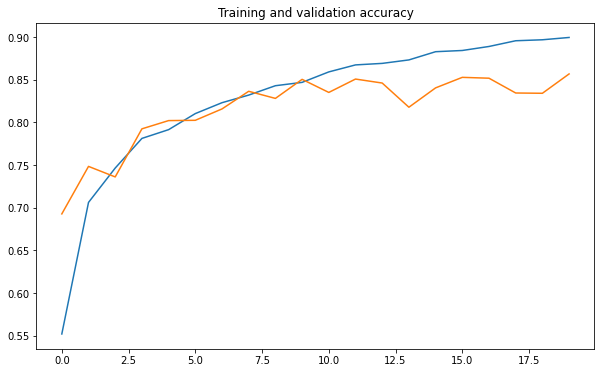

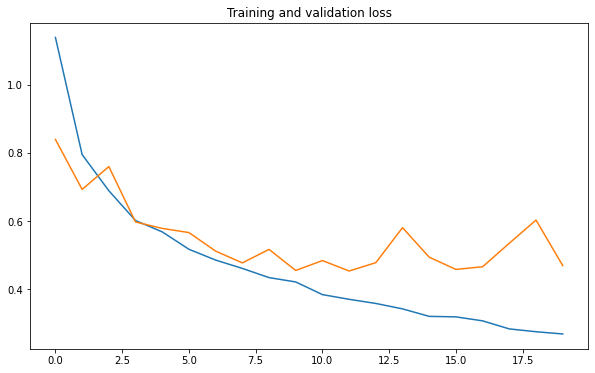

In [29]:
def evaluation(history):
    # evaluation
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    #-----------------------------------------------------------
    acc      = history.history['accuracy']
    val_acc  = history.history['val_accuracy']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    epochs   = range(len(acc)) # Get number of epochs

    #------------------------------------------------
    # Plot training and validation accuracy per epoch
    #------------------------------------------------
    plt.figure(figsize=(10,6))
    plt.plot  ( epochs,     acc )
    plt.plot  ( epochs, val_acc )
    plt.title ('Training and validation accuracy')
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.figure(figsize=(10,6))
    plt.plot  ( epochs,     loss )
    plt.plot  ( epochs, val_loss )
    plt.title ('Training and validation loss')
    
evaluation(history)

24/24 [==============================] - 11s 444ms/step - loss: 0.4701 - accuracy: 0.8567
Confusion Matrix
[[371   4   2   0  10  50]
 [  7 458   4   1   1   3]
 [  8   4 452  49  34   6]
 [  8   8  61 397  48   3]
 [ 14   3  24   9 457   3]
 [ 50   5   4   2   5 435]]
Classification Report
              precision    recall  f1-score   support

   buildings       0.81      0.85      0.83       437
      forest       0.95      0.97      0.96       474
     glacier       0.83      0.82      0.82       553
    mountain       0.87      0.76      0.81       525
         sea       0.82      0.90      0.86       510
      street       0.87      0.87      0.87       501

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



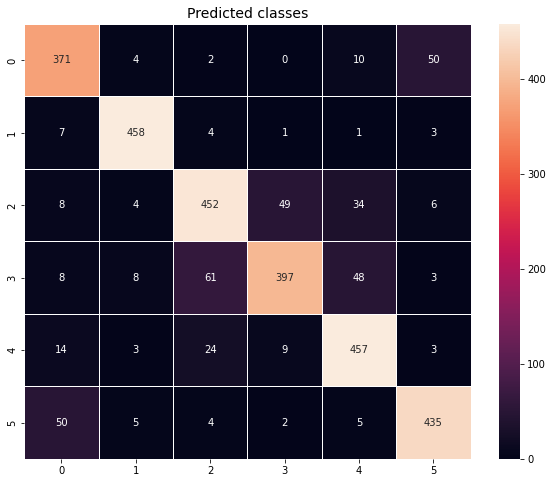

In [30]:
#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator)
model.evaluate(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['buildings','forest','glacier','mountain','sea','street']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))
plt.figure(figsize=(10,8))
plt.title('Predicted classes', size=14)
sns.heatmap(confusion_matrix(validation_generator.classes, y_pred), annot=True, fmt = '.0f',linewidths=.5)
plt.show()

### Testing the Model on the test set

In [53]:
test_dir = 'C:\\Users\\Jeffery Chan\\Desktop\\Group Project\\kaggle\\input\\intel-image-classification\\seg_test\\'

test_datagen = ImageDataGenerator( rescale = 1.0/255)
validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=128,
                                                         shuffle=False,
                                                         class_mode  = 'categorical',
                                                         target_size = (150, 150))

Found 3000 images belonging to 6 classes.


In [54]:
predictions = model.predict(validation_generator)

24/24 [==============================] - 11s 452ms/step


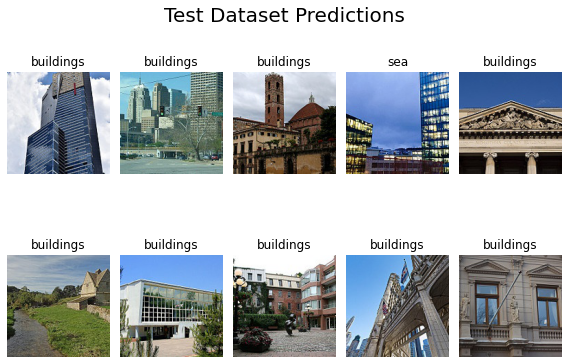

In [105]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(8, 6))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(validation_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

### CNN Hyperparameter Tuning 

In [98]:
def build_model(hp):    
    model = Sequential()
    
    model.add(Conv2D(filters = hp.Int('conv_1_filters',         #input layer
                               min_value = 32, 
                               max_value = 128, 
                               step = 16),
                               kernel_size = hp.Choice('conv_1_kernel', values = [3,5]),
                               activation='relu',
                               input_shape = (150,150,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = hp.Int('filters_1', 
                               min_value = 32, 
                               max_value = 128, 
                               step = 16),
                               kernel_size = hp.Choice('kernel_1', values = [3,5]),
                               activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters = hp.Int('filters_2', 
                               min_value = 32, 
                               max_value = 128, 
                               step = 16),
                               kernel_size = hp.Choice('kernel_2', values = [3,5]),
                               activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters = hp.Int('filters_3', 
                               min_value = 32, 
                               max_value = 128, 
                               step = 16),
                               kernel_size = hp.Choice('kernel_3', values = [3,5]),
                               activation='relu'))
  
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units',
                   min_value=32,
                   max_value=256,
                   step=32),
                   activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='softmax'))                  #output layer
  
    model.compile(optimizer = Adam(hp.Choice('learning_rate', values=[0.01,0.001,0.0001])),
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])
    return model

In [99]:
build_model(kt.HyperParameters())

In [101]:
tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=3 ,
                     directory = 'Group Project',
                     project_name = 'HPT cnn')

C:\Users\JEFFER~1\AppData\Local\Temp/ipykernel_18504/2894385084.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [102]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
conv_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
kernel_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
kernel_2 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
filters_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
kernel_3 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
learning_rate 

In [103]:
tuner.search(train_generator, epochs=3,validation_data=validation_generator)

Trial 5 Complete [10h 18m 45s]
val_accuracy: 0.6658888856569926

Best val_accuracy So Far: 0.7088888883590698
Total elapsed time: 18h 27m 38s
INFO:tensorflow:Oracle triggered exit


In [111]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]

In [112]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 96)        55392     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 96)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 35, 35, 96)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 48)        1

### Evaluating CNN with Regularisation

In [33]:
model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(150, 150, 3), activation='relu'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model2.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(512, activation='relu'))
model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.2))

model2.add(tf.keras.layers.Dense(6, activation='softmax'))

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [34]:
history2 = model2.fit(train_generator, 
                      epochs = epoch, 
                      validation_data = validation_generator, 
                      verbose = 1,
                      steps_per_epoch = 110)

Epoch 1/20
110/110 [==============================] - 439s 4s/step - loss: 1.9454 - accuracy: 0.5387 - val_loss: 11.6610 - val_accuracy: 0.2220
Epoch 2/20
110/110 [==============================] - 404s 4s/step - loss: 0.9107 - accuracy: 0.6666 - val_loss: 5.1690 - val_accuracy: 0.2043
Epoch 3/20
110/110 [==============================] - 404s 4s/step - loss: 0.7523 - accuracy: 0.7303 - val_loss: 3.9973 - val_accuracy: 0.2377
Epoch 4/20
110/110 [==============================] - 400s 4s/step - loss: 0.6889 - accuracy: 0.7522 - val_loss: 1.7104 - val_accuracy: 0.5157
Epoch 5/20
110/110 [==============================] - 402s 4s/step - loss: 0.6144 - accuracy: 0.7783 - val_loss: 0.7784 - val_accuracy: 0.7310
Epoch 6/20
110/110 [==============================] - 439s 4s/step - loss: 0.5696 - accuracy: 0.7994 - val_loss: 0.6381 - val_accuracy: 0.7777
Epoch 7/20
110/110 [==============================] - 571s 5s/step - loss: 0.5154 - accuracy: 0.8189 - val_loss: 0.5246 - val_accuracy: 0.816

### Saving the weights

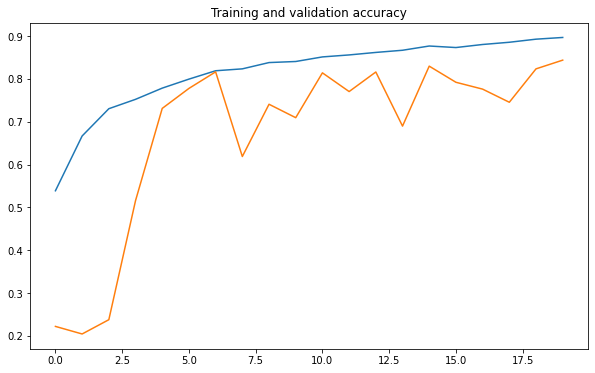

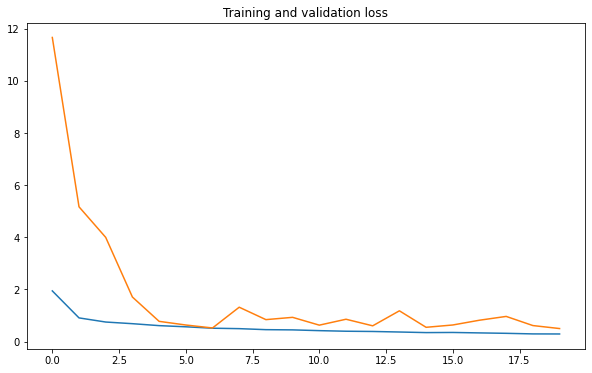

In [35]:
## Save the model
model2.save('CNN_with_Regulization.h5')
model2 = tf.keras.models.load_model('CNN_with_Regulization.h5')
evaluation(history2)

In [36]:
#Confution Matrix and Classification Report
Y_pred2 = model.predict(validation_generator)
model2.evaluate(validation_generator)

y_pred2 = np.argmax(Y_pred2, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred2))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred2, target_names=target_names))

24/24 [==============================] - 16s 634ms/step - loss: 0.5025 - accuracy: 0.8437
Confusion Matrix
[[371   4   2   0  10  50]
 [  7 458   4   1   1   3]
 [  8   4 452  49  34   6]
 [  8   8  61 397  48   3]
 [ 14   3  24   9 457   3]
 [ 50   5   4   2   5 435]]
Classification Report
              precision    recall  f1-score   support

   buildings       0.81      0.85      0.83       437
      forest       0.95      0.97      0.96       474
     glacier       0.83      0.82      0.82       553
    mountain       0.87      0.76      0.81       525
         sea       0.82      0.90      0.86       510
      street       0.87      0.87      0.87       501

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



### Transfer Learning (VGG-16)

In [37]:
VGG16 = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False,input_shape=(150, 150, 3))

train_generator_ordered =  test_datagen.flow_from_directory(train_dir,
                                                         batch_size=128,
                                                         shuffle=False,
                                                         class_mode  = 'categorical',
                                                         target_size = (150, 150)) # it is very important to include shuffle=False

58889256/58889256 [==============================] - 5s 0us/step
Found 14026 images belonging to 6 classes.


In [38]:
def PCA_plot(train_features,test_features):
    n_train, x, y, z = train_features.shape
    n_test, x, y, z = test_features.shape
    numFeatures = x * y * z

    from sklearn import decomposition

    pca = decomposition.PCA(n_components = 2)

    X = train_features.reshape((n_train, x*y*z))
    pca.fit(X)
    C = pca.transform(X) # Représentation des individus dans les nouveaux axe
    C1 = C[:,0]
    C2 = C[:,1]
    ### Figures
    class_names = ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

    plt.subplots(figsize=(8,8))

    for i, class_name in enumerate(class_names):
        plt.scatter(C1[train_generator.classes == i], C2[train_generator.classes == i], label = class_name, alpha=0.4)
    plt.legend()
    plt.title("PCA Projection")
    plt.show()
    
train_featuresVGG16 = VGG16.predict(train_generator_ordered)
test_featuresVGG16 = VGG16.predict(validation_generator)

24/24 [==============================] - 296s 12s/step


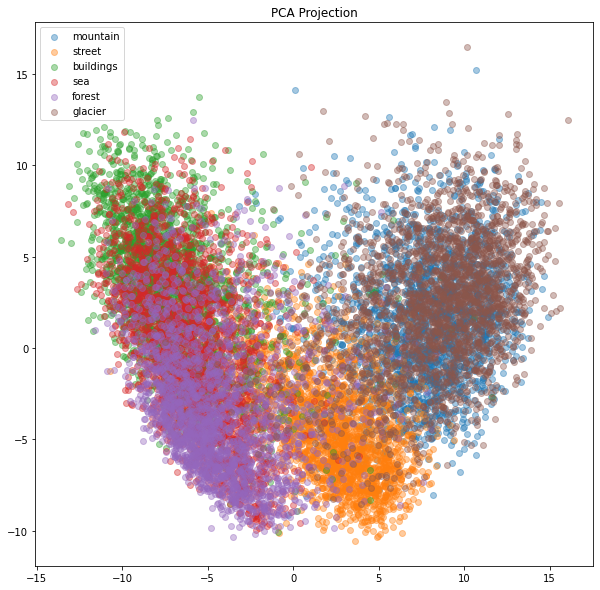

In [39]:
PCA_plot(train_featuresVGG16,test_featuresVGG16)

In [41]:
#freeze the base model
VGG16.trainable = False
#Create new model on top
model3=tf.keras.models.Sequential()
model3.add(VGG16)
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(512, activation='relu'))
model3.add(tf.keras.layers.Dense(128, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(6, activation='softmax'))

In [43]:
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

# early stopping: we can use EarlyStopping which is one of keras callbackes to stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor='loss', patience=5)
epoch = 20 # we can set it to a large value because there is early stopping
history3 = model3.fit(train_generator, 
                                 epochs = epoch, 
                                 validation_data = validation_generator, 
                                 verbose = 1,
                                 steps_per_epoch = 110,
                                 callbacks = [earlystop]) # steps_per_epoch  = total number of samples // batch_size = 14034/128

Epoch 1/20
110/110 [==============================] - 1636s 15s/step - loss: 0.5917 - accuracy: 0.7770 - val_loss: 0.3750 - val_accuracy: 0.8590
Epoch 2/20
110/110 [==============================] - 1811s 16s/step - loss: 0.4447 - accuracy: 0.8325 - val_loss: 0.3780 - val_accuracy: 0.8570
Epoch 3/20
110/110 [==============================] - 1893s 17s/step - loss: 0.4167 - accuracy: 0.8487 - val_loss: 0.3664 - val_accuracy: 0.8610
Epoch 4/20
110/110 [==============================] - 1910s 17s/step - loss: 0.3852 - accuracy: 0.8593 - val_loss: 0.3341 - val_accuracy: 0.8700
Epoch 5/20
110/110 [==============================] - 1769s 16s/step - loss: 0.3724 - accuracy: 0.8622 - val_loss: 0.3246 - val_accuracy: 0.8750
Epoch 6/20
110/110 [==============================] - 1737s 16s/step - loss: 0.3430 - accuracy: 0.8724 - val_loss: 0.3457 - val_accuracy: 0.8707
Epoch 7/20
110/110 [==============================] - 1747s 16s/step - loss: 0.3353 - accuracy: 0.8760 - val_loss: 0.3489 - val_ac

In [44]:
model3.save('VGG16.h5')
model3 = tf.keras.models.load_model('VGG16.h5')

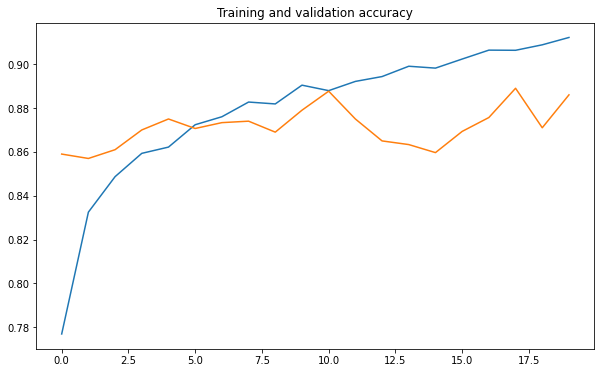

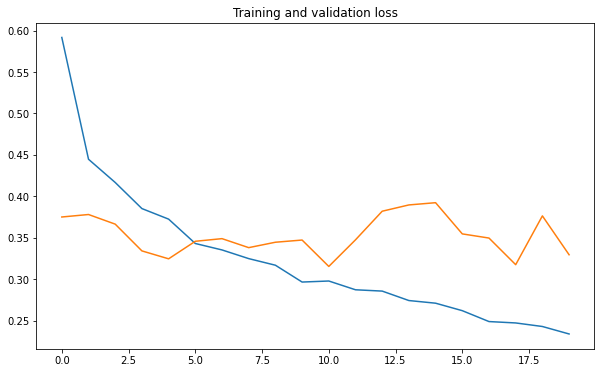

In [45]:
evaluation(history3)

24/24 [==============================] - 290s 12s/step - loss: 0.3295 - accuracy: 0.8860
Confusion Matrix
[[403   0   0   0   3  31]
 [  2 469   1   0   1   1]
 [  3   2 448  79  19   2]
 [  3   2  56 438  26   0]
 [ 10   4  13  28 454   1]
 [ 49   2   0   0   4 446]]
Classification Report
              precision    recall  f1-score   support

   buildings       0.86      0.92      0.89       437
      forest       0.98      0.99      0.98       474
     glacier       0.86      0.81      0.84       553
    mountain       0.80      0.83      0.82       525
         sea       0.90      0.89      0.89       510
      street       0.93      0.89      0.91       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



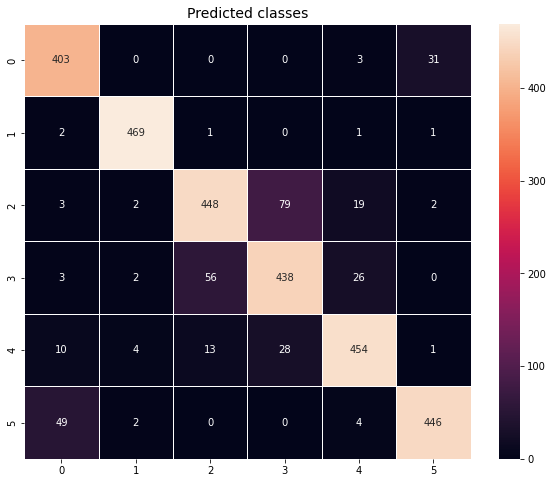

In [46]:
Y_pred3 = model3.predict(validation_generator)
model3.evaluate(validation_generator)
y_pred3 = np.argmax(Y_pred3, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred3))
print('Classification Report')
target_names = ['buildings','forest','glacier','mountain','sea','street']
print(classification_report(validation_generator.classes, y_pred3, target_names=target_names))
plt.figure(figsize=(10,8))
plt.title('Predicted classes', size=14)
sns.heatmap(confusion_matrix(validation_generator.classes, y_pred3), annot=True, fmt = '.0f',linewidths=.5)
plt.show()

### Transfer Learning (Inception V3)

24/24 [==============================] - 60s 3s/step


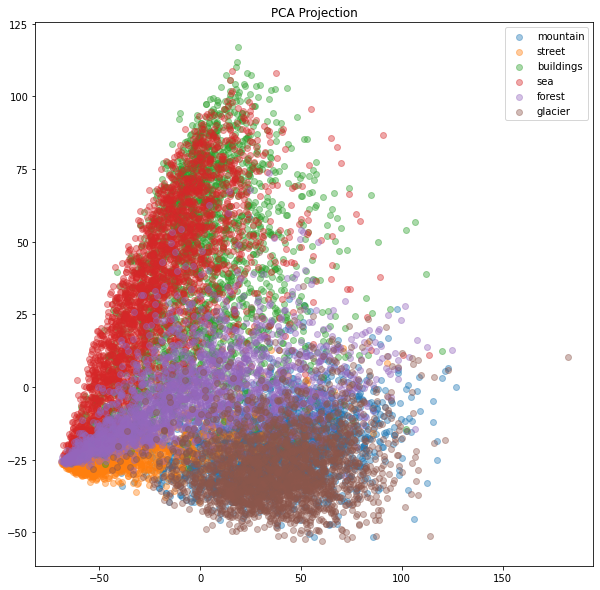

In [47]:
InceptionV3 = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False,input_shape=(150, 150, 3))

train_featuresInceptionV3 = InceptionV3.predict(train_generator_ordered)
test_featuresInceptionV3 = InceptionV3.predict(validation_generator)
PCA_plot(train_featuresInceptionV3,test_featuresInceptionV3)

In [48]:
#freeze the base model
InceptionV3.trainable = False
model4=tf.keras.models.Sequential()
model4.add(InceptionV3)
model4.add(tf.keras.layers.Flatten())
model4.add(tf.keras.layers.Dense(512, activation='relu'))
model4.add(tf.keras.layers.Dense(128, activation='relu'))
model4.add(tf.keras.layers.Dropout(0.2))
model4.add(tf.keras.layers.Dense(6, activation='softmax'))

In [49]:
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

# early stopping: we can use EarlyStopping which is one of keras callbackes to stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor='loss', patience=5)
epoch = 20 # we can set it to a large value because there is early stopping
history4 = model4.fit(train_generator, 
                                 epochs = epoch, 
                                 validation_data = validation_generator, 
                                 verbose = 1,
                                 steps_per_epoch = 110,
                                 callbacks = [earlystop]) # steps_per_epoch  = total number of samples // batch_size = 14034/128

Epoch 1/20
110/110 [==============================] - 426s 4s/step - loss: 1.0749 - accuracy: 0.7679 - val_loss: 0.3404 - val_accuracy: 0.8760
Epoch 2/20
110/110 [==============================] - 389s 4s/step - loss: 0.4114 - accuracy: 0.8543 - val_loss: 0.3311 - val_accuracy: 0.8743
Epoch 3/20
110/110 [==============================] - 382s 3s/step - loss: 0.3847 - accuracy: 0.8655 - val_loss: 0.2967 - val_accuracy: 0.8933
Epoch 4/20
110/110 [==============================] - 381s 3s/step - loss: 0.3721 - accuracy: 0.8626 - val_loss: 0.3117 - val_accuracy: 0.8883
Epoch 5/20
110/110 [==============================] - 407s 4s/step - loss: 0.3364 - accuracy: 0.8802 - val_loss: 0.2737 - val_accuracy: 0.8970
Epoch 6/20
110/110 [==============================] - 439s 4s/step - loss: 0.3275 - accuracy: 0.8803 - val_loss: 0.2859 - val_accuracy: 0.8947
Epoch 7/20
110/110 [==============================] - 357s 3s/step - loss: 0.3187 - accuracy: 0.8860 - val_loss: 0.2760 - val_accuracy: 0.9020

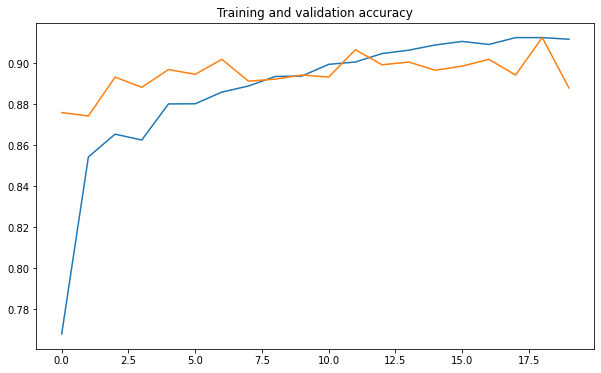

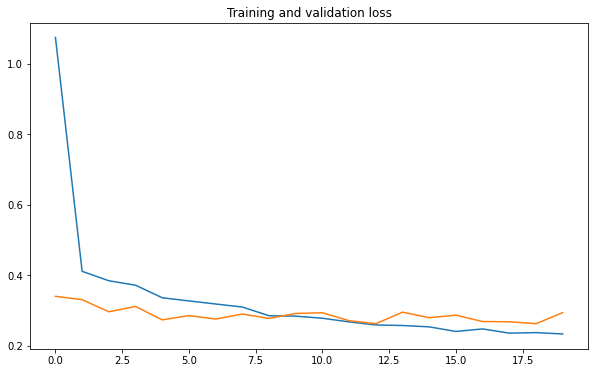

In [51]:
evaluation(history4)

24/24 [==============================] - 48s 2s/step - loss: 0.2942 - accuracy: 0.8880
Confusion Matrix
[[412   2   0   0   6  17]
 [  0 468   1   2   2   1]
 [  0   5 376 145  27   0]
 [  1   4  29 471  17   3]
 [  3   3   1   9 493   1]
 [ 47   1   0   3   6 444]]
Classification Report
              precision    recall  f1-score   support

   buildings       0.89      0.94      0.92       437
      forest       0.97      0.99      0.98       474
     glacier       0.92      0.68      0.78       553
    mountain       0.75      0.90      0.82       525
         sea       0.89      0.97      0.93       510
      street       0.95      0.89      0.92       501

    accuracy                           0.89      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.90      0.89      0.89      3000



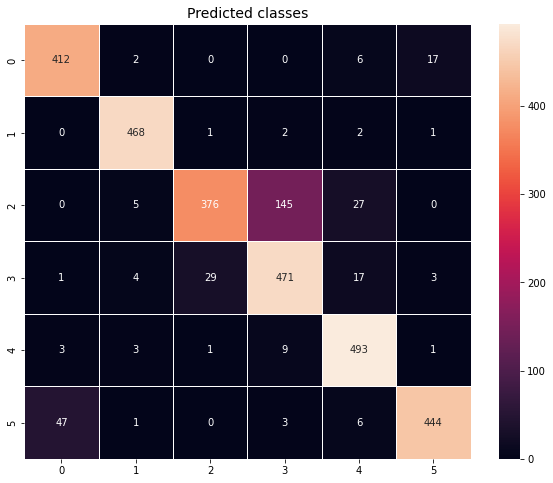

In [52]:
Y_pred4 = model4.predict(validation_generator)
model4.evaluate(validation_generator)
y_pred4 = np.argmax(Y_pred4, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred4))
print('Classification Report')
target_names = ['buildings','forest','glacier','mountain','sea','street']
print(classification_report(validation_generator.classes, y_pred4, target_names=target_names))
plt.figure(figsize=(10,8))
plt.title('Predicted classes', size=14)
sns.heatmap(confusion_matrix(validation_generator.classes, y_pred4), annot=True, fmt = '.0f',linewidths=.5)
plt.show()